#### Кейс №2 - Приложение доставки
_Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – <br> 
предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.<br>
Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой <br>
рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.<br>
Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого <br>
нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.<br>
Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех <br>
пользователей.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import pingouin as pg
import scipy.stats as stats
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal

In [8]:
users_data = pd.read_csv('ab_users_data.csv', parse_dates = ['time', 'date'])
users_data.head(3)

user_id  order_id        action                time       date  group
0      964      1255  create_order 2022-08-26 00:00:19 2022-08-26      0
1      965      1256  create_order 2022-08-26 00:02:21 2022-08-26      1
2      964      1257  create_order 2022-08-26 00:02:27 2022-08-26      0

In [16]:
users_data.dtypes

user_id              int64
order_id             int64
action              object
time        datetime64[ns]
date        datetime64[ns]
group                int64
dtype: object

In [9]:
ab_orders = pd.read_csv('ab_orders.csv', parse_dates = ['creation_time'])
ab_orders.head(3)

order_id       creation_time       product_ids
0      1255 2022-08-26 00:00:19  {75, 22, 53, 84}
1      1256 2022-08-26 00:02:21      {56, 76, 39}
2      1257 2022-08-26 00:02:27  {76, 34, 41, 38}

In [34]:
ab_orders.dtypes

order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

In [10]:
#Преобразуем множества product_ids в список"
ab_orders['product_ids'] = ab_orders['product_ids'].apply(lambda x: list(map(int, x.strip('{}').split(','))))
ab_orders.head(3)

order_id       creation_time       product_ids
0      1255 2022-08-26 00:00:19  [75, 22, 53, 84]
1      1256 2022-08-26 00:02:21      [56, 76, 39]
2      1257 2022-08-26 00:02:27  [76, 34, 41, 38]

In [11]:
ab_products = pd.read_csv('ab_products.csv')
ab_products.head(3)

product_id                     name  price
0           1                    сахар  150.0
1           2  чай зеленый в пакетиках   50.0
2           3      вода негазированная   80.4

In [19]:
ab_products.dtypes

product_id      int64
name           object
price         float64
dtype: object

_Замерджим таблицы

In [12]:
merged_1 = pd.merge(users_data, ab_orders)
merged_1 = merged_1.explode('product_ids')
merged_1.rename(columns = {'product_ids':'product_id'}, inplace = True)
merged = pd.merge(merged_1, ab_products)
merged.head(3)

user_id  order_id        action                time       date  group  \
0      964      1255  create_order 2022-08-26 00:00:19 2022-08-26      0   
1      987      1287  create_order 2022-08-26 00:31:36 2022-08-26      0   
2     1073      1403  create_order 2022-08-26 03:01:40 2022-08-26      1   

        creation_time product_id            name  price  
0 2022-08-26 00:00:19         75  сок ананасовый  120.0  
1 2022-08-26 00:31:36         75  сок ананасовый  120.0  
2 2022-08-26 03:01:40         75  сок ананасовый  120.0

_Посмотрим как изменился RPU (доход с пользователя) <br>
_Проверим взаимовзязь между группой и RPU <br>
𝐻0 : взаимосвязи между переменными нет<br>
𝐻1 : взаимосвязь есть

##### Возьмем здесь и дальше только те заказы, которые не были отменены 

In [13]:
merged = merged[merged.action != 'cancel_order']
revenue_by_user =  merged.groupby(['group', 'user_id'], as_index = False).agg({'price': 'sum'}).rename(columns={'price':'RPU'})
revenue_by_user.head(3)

group  user_id     RPU
0      0      964   718.9
1      0      966    85.0
2      0      968  1590.7

_Визуализация распределения дохода с пользователя

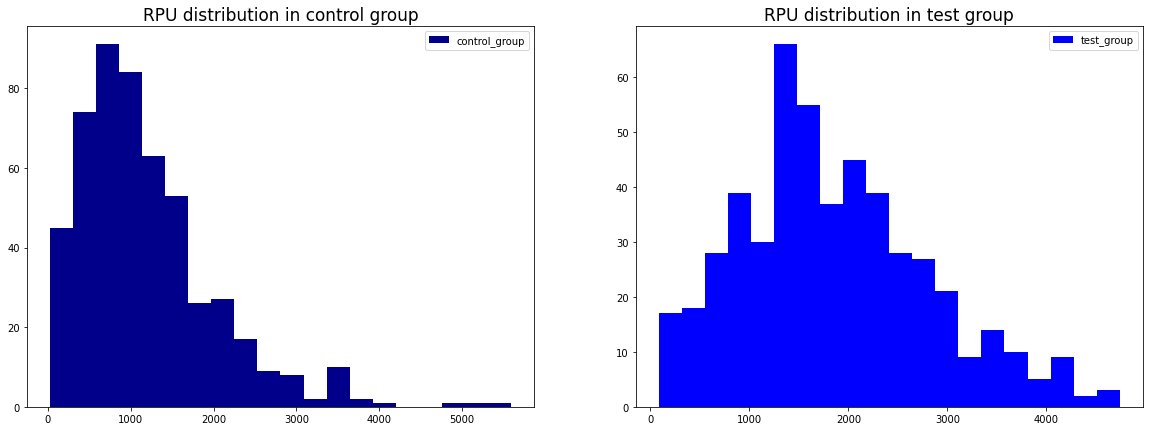

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax2.set_title('RPU distribution in test group', fontsize = 17)
ax2.hist(revenue_by_user[revenue_by_user.group ==1].RPU, bins=20, label='test_group', color='blue')
ax2.legend()

ax1.hist(revenue_by_user[revenue_by_user.group ==0].RPU, bins=20, label='control_group', color='darkblue')
ax1.legend()
ax1.set_title('RPU distribution in control group', fontsize = 17)
plt.show()

In [17]:
pg.normality(data = revenue_by_user, dv = 'RPU', group = 'group', method = 'normaltest')

W          pval  normal
0  158.042704  4.802449e-35   False
1   21.921081  1.737392e-05   False

_Для проверки гипотезы я использую U-критерий Манна Уитни, поскольку переменная RPU количественная, а group
КАТЕГОРИАЛЬНАЯ. И распределения являются ненормальными

In [30]:
test = revenue_by_user[revenue_by_user.group ==1].RPU.sort_values()
control = revenue_by_user[revenue_by_user.group ==0].RPU.sort_values()

In [31]:
statistic, p_value = mannwhitneyu(test, control)

# Вывод результатов
print("Статистика U:", statistic)
print("p-значение:", p_value)

Статистика U: 185331.5
p-значение: 4.991032611140459e-33


_После использования U-критерия Манна-Уитни нулевая гипотеза отклоняется, так как p-value < 0.05. Это означает, что существует статистически значимая связь. В нашем эксперименте было обнаружено статистически значимое различие между рангами доходов пользователей в разных группах.

_Проверим гипотезу используя bootstrap

In [20]:
control_df = revenue_by_user[revenue_by_user.group == 0]
bootstrap((control_df.RPU, ),np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=940.9, high=1091.9999999999998), standard_error=38.23399928315348)

In [21]:
test_df = revenue_by_user[revenue_by_user.group == 1]
bootstrap((test_df.RPU, ),np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=1627.3, high=1824.55), standard_error=51.96365079932702)

_Доверительные интервалы не пересекаются, следовательно различие между медианами для среднего дохода с клиента являются стат 
значимыми

_Посмотрим как изменились количества заказов на каждого пользователя

In [35]:
orders_by_user = merged.groupby(['group', 'user_id'], as_index = False).agg({'order_id': 'nunique'}) \
    .rename(columns={'order_id':'count_of_orders'})
orders_by_user.head(3)

group  user_id  count_of_orders
0      0      964                2
1      0      966                1
2      0      968                3

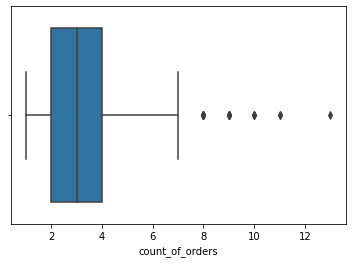

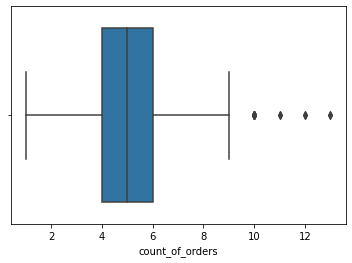

In [28]:
sns.boxplot(data = orders_by_user[orders_by_user.group == 0], x = 'count_of_orders')
plt.show()
sns.boxplot(data = orders_by_user[orders_by_user.group == 1], x = 'count_of_orders')

_Визуализация распределения количества заказов на каждого пользователя

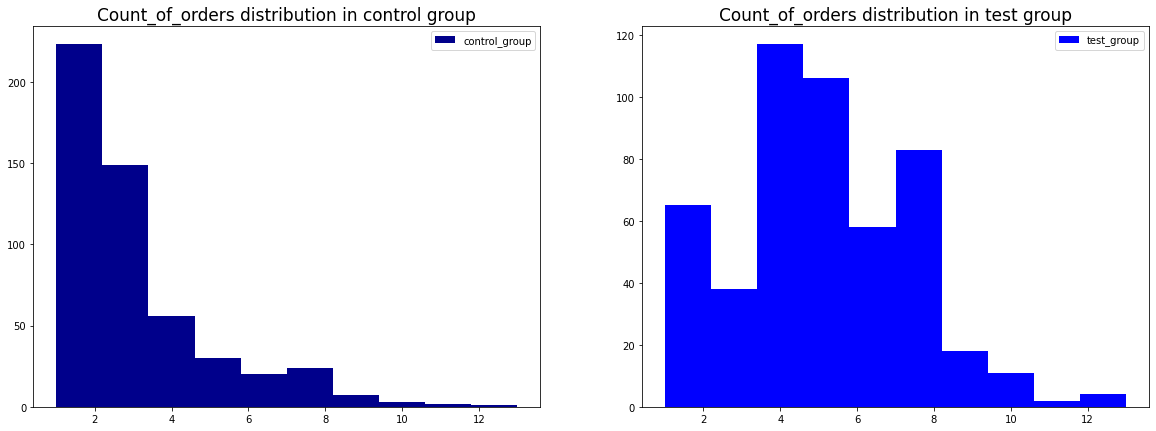

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax2.set_title('Сount_of_orders distribution in test group', fontsize = 17)
ax2.hist(orders_by_user[orders_by_user.group ==1].count_of_orders, label='test_group', color='blue')
ax2.legend()

ax1.hist(orders_by_user[orders_by_user.group ==0].count_of_orders, label='control_group', color='darkblue')
ax1.legend()
ax1.set_title('Сount_of_orders distribution in control group', fontsize = 17)
plt.show()

_Для проверки гипотезы я использую U-критерий Манна-Уитни, поскольку переменная count_of_orders количественная, а group <br>
КАТЕГОРИАЛЬНАЯ, а также так как U-критерий Манна-Уитни не чувствителен к выбросам, которые мы здесь наблюдаем.<br>
И распределения являются ненормальными <br>
_Проверим взаимовзязь между группой и count_of_orders<br>
𝐻0 : взаимосвязи между переменными нет<br>
𝐻1 : взаимосвязь есть

In [26]:
test = orders_by_user[orders_by_user.group ==1].count_of_orders.sort_values()
control = orders_by_user[orders_by_user.group ==0].count_of_orders.sort_values()

In [27]:
statistic, p_value = mannwhitneyu(test, control)

# Вывод результатов
print("Статистика U:", statistic)
print("p-значение:", p_value)

Статистика U: 197357.5
p-значение: 6.987139829766148e-49


_Нулевая гипотеза ОТКЛОНЯЕТСЯ, поскольку p-value < 0. 05. Значит, ВЗАИМОСВЯЗЬ ЕСТЬ. <br>
В нашем эксперименте было получено стат значимое различие между рангами количества заказов между группами.<br>
<br>
_Проверим гипотезу используя bootstrap

In [108]:
control_df = orders_by_user[orders_by_user.group == 0]
bootstrap((control_df.count_of_orders, ),np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=3.0, high=3.0), standard_error=0.03315131491998596)

In [109]:
test_df = orders_by_user[orders_by_user.group == 1]
bootstrap((test_df.count_of_orders, ),np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=5.0, high=5.0), standard_error=0.050918343958458484)

_Получены стат значимые различия в медиане количества заказов на покупателя: у тетстовой группы она значительно выше.<br>
Возможно людям понравилась новая фича и они стали делать покупки чаще.

_Посмотрим как изменились количества товаров на каждого пользователя

In [52]:
count_by_user = merged.groupby(['group', 'user_id'], as_index = False).agg({'product_id': 'count'}) \
    .rename(columns={'product_id':'count_of_goods'})
count_by_user.head(3)

group  user_id  count_of_goods
0      0      964               8
1      0      966               2
2      0      968              11

_Визуализация распределения количества товаров на 1 пользователя

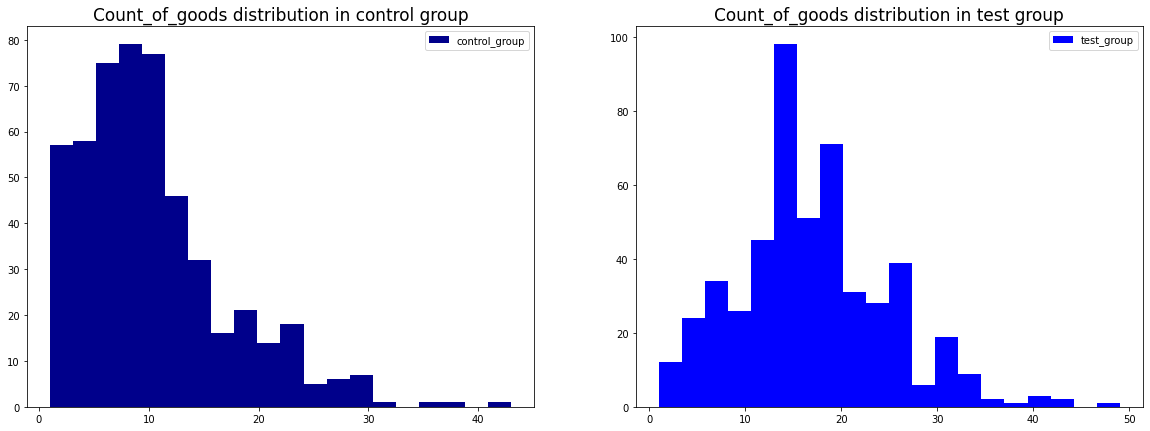

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax2.set_title('Сount_of_goods distribution in test group', fontsize = 17)
ax2.hist(count_by_user[count_by_user.group ==1].count_of_goods, bins=20, label='test_group', color='blue')
ax2.legend()

ax1.hist(count_by_user[count_by_user.group ==0].count_of_goods, bins=20, label='control_group', color='darkblue')
ax1.legend()
ax1.set_title('Сount_of_goods distribution in control group', fontsize = 17)
plt.show()

In [30]:
pg.normality(data = count_by_user, dv = 'count_of_goods', group = 'group', method = 'normaltest')

W          pval  normal
0  122.122425  3.030068e-27   False
1   30.267881  2.675551e-07   False

_Для проверки гипотезы я использую U-критерий Манна Уитни, поскольку переменная count_of_goods количественная, а group <br>
КАТЕГОРИАЛЬНАЯ. И распределения являются ненормальными <br>
_Проверим взаимовзязь между группой и count_of_goods<br>
𝐻0 : взаимосвязи между переменными нет<br>
𝐻1 : взаимосвязь есть

In [31]:
test = count_by_user[count_by_user.group ==1].count_of_goods.sort_values()
control = count_by_user[count_by_user.group ==0].count_of_goods.sort_values()

In [32]:
statistic, p_value = mannwhitneyu(test, control)

# Вывод результатов
print("Статистика U:", statistic)
print("p-значение:", p_value)

Статистика U: 193562.0
p-значение: 5.724370781704199e-43


_Нулевая гипотеза ОТКЛОНЯЕТСЯ, поскольку p-value < 0. 05. Значит, ВЗАИМОСВЯЗЬ ЕСТЬ. <br>
В нашем эксперименте было получено стат значимое различие между рангами количества товаров между группами.<br>
<br>
_Проверим гипотезу используя bootstrap

In [114]:
control_df = count_by_user[count_by_user.group == 0]
bootstrap((control_df.count_of_goods, ),np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=9.0, high=10.0), standard_error=0.35790024478017946)

In [115]:
test_df = count_by_user[count_by_user.group == 1]
bootstrap((test_df.count_of_goods, ),np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=15.0, high=17.0), standard_error=0.4272885839905998)

_Медианы количества покупок по юзерам между группами отличаются стат значимо

_Мне интересно посмотреть какие товары люди покупали в контрольной чаще всего и какие покупали в тестовой группе

In [33]:
group_0 = merged[merged.group ==0].name.value_counts().to_frame().reset_index().sort_values('name', ascending = False) \
    .rename(columns = {'name': 'count_0'})
group_0.head()

index  count_0
0              курица      127
1              бананы      116
2  масло подсолнечное      110
4                хлеб      110
3               батон      110

In [34]:
group_1 = merged[merged.group ==1].name.value_counts().to_frame().reset_index().sort_values('name', ascending = False) \
    .rename(columns = {'name': 'count_1'})
group_1.head(3)

index  count_1
0    батон      183
1    сахар      181
2  печенье      179

_Батон в конрольной группе купили 110 раз, а в тестовой 183 раз. Интересно, явяляется ли это и другие изменения стат значимыми

In [54]:
products_df = pd.merge(group_0, group_1).sort_values(['count_1', 'count_0'], ascending= False)
products_df.head(3)

index  count_0  count_1
4     батон      110      183
7     сахар      104      181
20  печенье       92      179

_Только у 1 товара не изменилось количество его покупок, остальные увеличились

In [55]:
products_df[products_df.count_0 >= products_df.count_1]

index  count_0  count_1
81  чайный гриб       15       15

In [56]:
by_goods =  merged.groupby(['group', 'name'], as_index = False).agg({'date': 'count'}) \
    .rename(columns = {'date': 'counts'}).sort_values('counts', ascending= False)
by_goods.head(3)

group     name  counts
92       1    батон     183
142      1    сахар     181
137      1  печенье     179

_Визуализация распределения частоты приорбетения единиц товаров

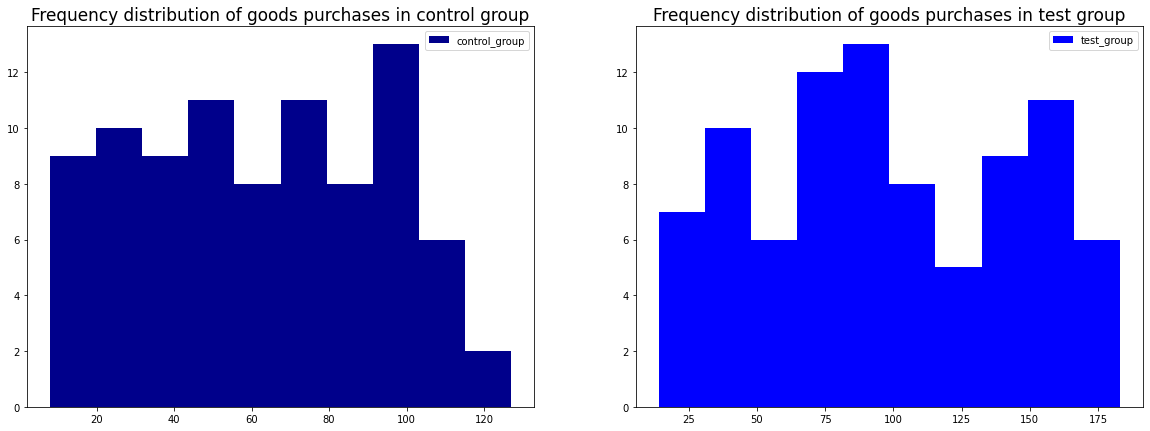

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax2.set_title('Frequency distribution of goods purchases in test group', fontsize = 17)
ax2.hist(by_goods[by_goods.group ==1].counts, label='test_group', color='blue')
ax2.legend()

ax1.hist(by_goods[by_goods.group ==0].counts, label='control_group', color='darkblue')
ax1.legend()
ax1.set_title('Frequency distribution of goods purchases in control group', fontsize = 17)
plt.show()

_Для проверки гипотезы я использую U-критерий Манна Уитни, поскольку переменная counts количественная, а group <br>
КАТЕГОРИАЛЬНАЯ. И распределения являются ненормальными<br>
_Проверим взаимовзязь между группой и counts<br>
𝐻0 : взаимосвязи между переменными нет<br>
𝐻1 : взаимосвязь есть

In [38]:
test = by_goods[by_goods.group ==1].counts.sort_values()
control = by_goods[by_goods.group ==0].counts.sort_values()

In [39]:
statistic, p_value = mannwhitneyu(test, control)

# Вывод результатов
print("Статистика U:", statistic)
print("p-значение:", p_value)

Статистика U: 5343.0
p-значение: 2.7355638002227808e-06


_Нулевая гипотеза ОТКЛОНЯЕТСЯ, поскольку p-value < 0. 05. Значит, ВЗАИМОСВЯЗЬ ЕСТЬ. <br>
В нашем эксперименте было получено стат значимое различие между рангами количества купленных товаров между группами.<br>
<br>
_Проверим гипотезу используя bootstrap

In [124]:
control_df = by_goods[by_goods.group == 0]
bootstrap((control_df.counts, ), np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=50.0, high=75.0), standard_error=6.926088094261646)

In [125]:
test_df = by_goods[by_goods.group == 1]
bootstrap((test_df.counts, ),np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=76.0, high=109.0), standard_error=7.153279965225042)

_Покупатели из тестовой группы стали покупать чаще товары. Медиана от каждой позиции купденных товаров в тестовой группе
увеличилась стат значимо.Получается, благодаря умной системе покупатели из тестовой группы по всем позизиям (кроме чайный гриб,
где количество покупок не изменилось) купили большее количество каждого товара. И эта разница стат значима

_Давайте дополнительно проверим распределние количества заказов по датам по каждой группе

In [58]:
merged.head()

user_id  order_id        action                time       date  group  \
0      964      1255  create_order 2022-08-26 00:00:19 2022-08-26      0   
1      987      1287  create_order 2022-08-26 00:31:36 2022-08-26      0   
2     1073      1403  create_order 2022-08-26 03:01:40 2022-08-26      1   
3     1089      1424  create_order 2022-08-26 04:01:22 2022-08-26      1   
4     1139      1495  create_order 2022-08-26 06:04:05 2022-08-26      1   

        creation_time product_id            name  price  
0 2022-08-26 00:00:19         75  сок ананасовый  120.0  
1 2022-08-26 00:31:36         75  сок ананасовый  120.0  
2 2022-08-26 03:01:40         75  сок ананасовый  120.0  
3 2022-08-26 04:01:22         75  сок ананасовый  120.0  
4 2022-08-26 06:04:05         75  сок ананасовый  120.0

In [14]:
df = merged.groupby(['group', 'date'], as_index = False).agg({'order_id':'nunique'})
df.head()

group       date  order_id
0      0 2022-08-26       628
1      0 2022-08-27       112
2      0 2022-08-28        92
3      0 2022-08-29       112
4      0 2022-08-30        98

In [15]:
df.date = df.date.dt.date

In [97]:
df.dtypes

group        int64
date        object
order_id     int64
dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

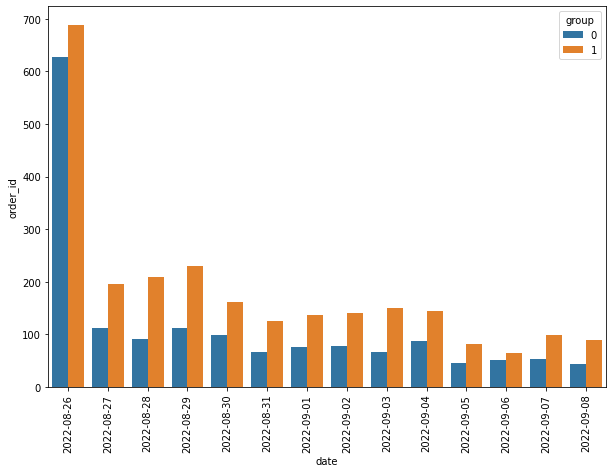

In [16]:
plt.figure(figsize = (10,7))
sns.barplot(data = df, x = 'date', y = 'order_id', hue = 'group')
plt.xticks(rotation=90)

#### Из графика мы наблюдаем уменьшение количества заказов изо дня в день для обеих групп после начала эксперимента.
#### Чтобы выяснить причину нужно дальше исследовать данные, но возможно запуск новой системы каким-то образом мог быть причиной. Но также причиной могло быть и что-то другое, например сезонность, праздники.  Но проверить в любом случае стоит. Новая системе дает бизнесу больший доход с пользователя по сравнению с контрольной группой, и если причина спада количества заказов не в ней, то запускать стоит.